References:

*   https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3
*   http://ethen8181.github.io/machine-learning/time_series/1_exponential_smoothing.html
*   https://towardsdatascience.com/5-types-of-plots-that-will-help-you-with-time-series-analysis-b63747818705
*   https://machinelearningmastery.com/time-series-data-visualization-with-python/ 



In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
!pip install statsmodels==0.12.2

     |████████████████████████████████| 9.5 MB 24.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
import pandas as pd

#DATA_PATH = '/content/drive/My Drive/my_colab/'
DATA_PATH = './Data/'
AMZN_DATA = f'{DATA_PATH}AMZN/AMZN.csv'

amzn_df = pd.read_csv(AMZN_DATA, parse_dates=['Date'])

amzn_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,136.250000,136.610001,133.139999,133.899994,133.899994,7599900
1,2010-01-05,133.429993,135.479996,131.809998,134.690002,134.690002,8851900
2,2010-01-06,134.600006,134.729996,131.649994,132.250000,132.250000,7178800
3,2010-01-07,132.009995,132.320007,128.800003,130.000000,130.000000,11030200
4,2010-01-08,130.559998,133.679993,129.029999,133.520004,133.520004,9830500


Line plot

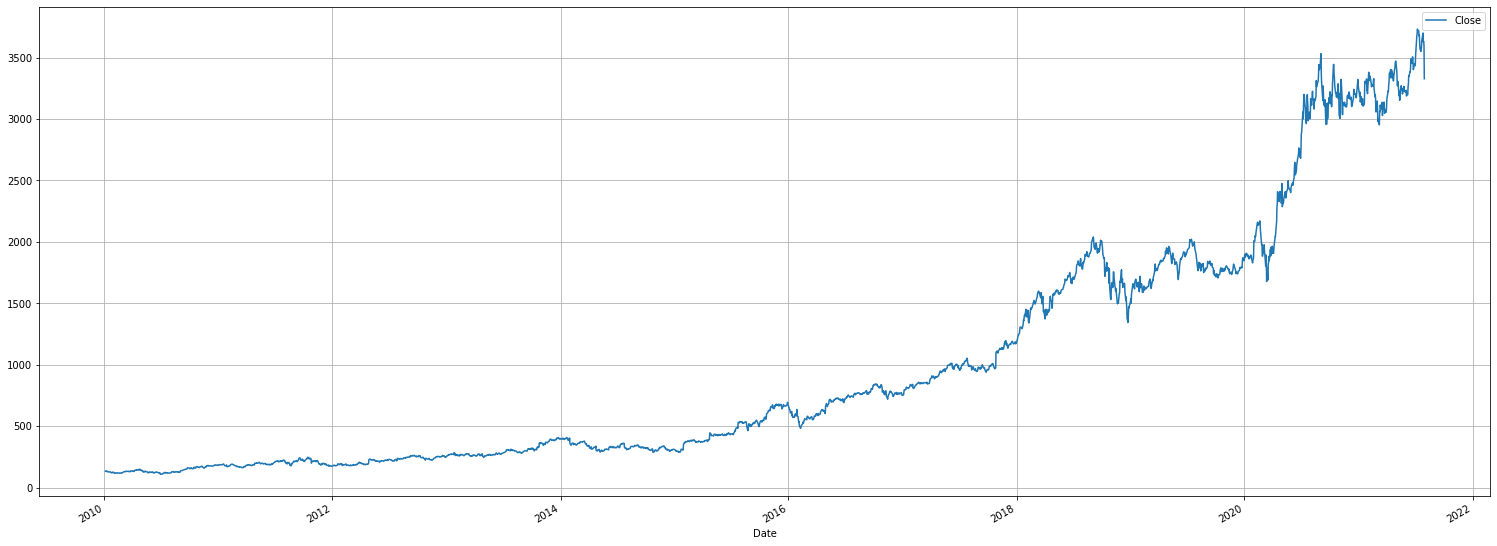

In [4]:
import plotly.express as px

def plot_ts_window(df, dt_col, series_col, start=None, end=None):   
    df = df[[dt_col, series_col]]
    start = str(df[dt_col].min()) if start is None else start
    end = str(df[dt_col].max()) if end is None else end
    win_df = df[(df[dt_col] >= start) & (df[dt_col] <= end)]
    #fig = px.line(win_df, x = dt_col, y = series_col)
    #fig.show()
    win_df.set_index(dt_col).plot(figsize=(26,10), grid=True)

plot_ts_window(amzn_df, 'Date', 'Close')

Decomposition

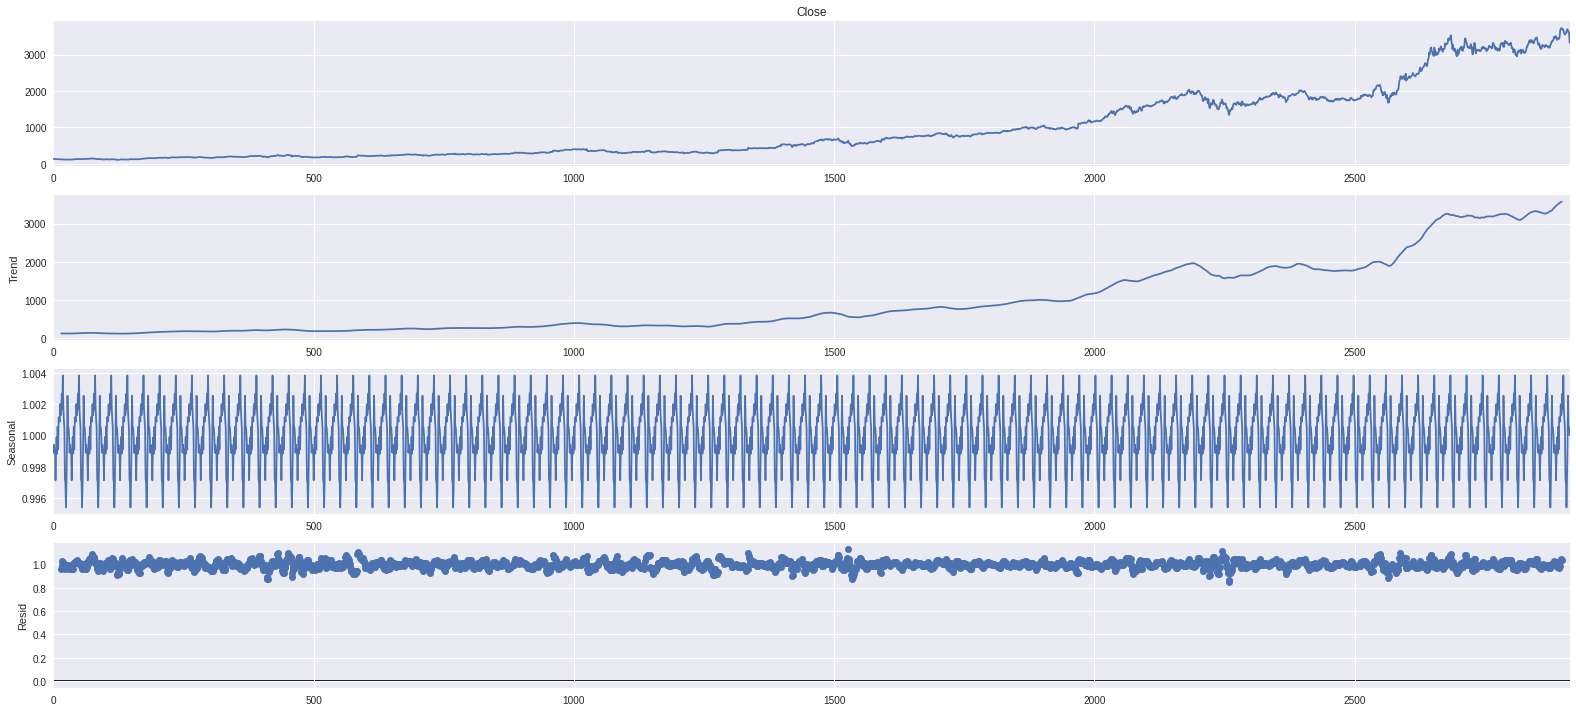

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot

# plotting
import seaborn as sns 
import matplotlib.pyplot as plt

# settings
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (22, 10)

decomposition = seasonal_decompose(amzn_df['Close'], model='multiplicative', period=31)
decomposition.plot();

Autocorrelation plots

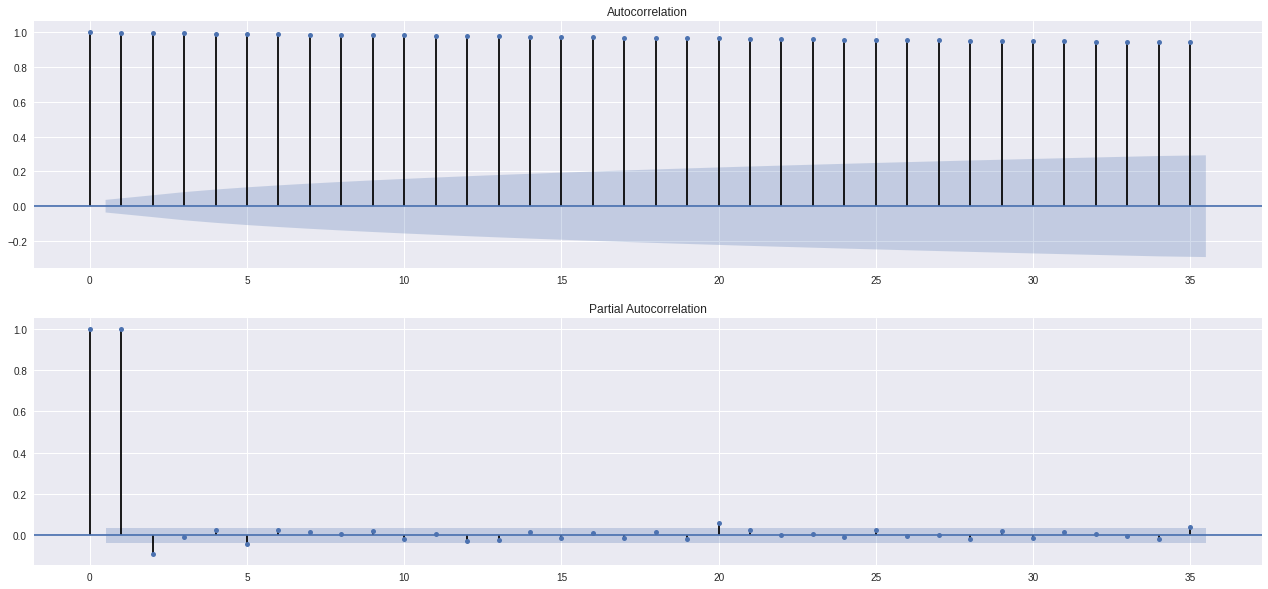

In [6]:
fig, ax = plt.subplots(2)
plot_acf(amzn_df['Close'], ax=ax[0])
plot_pacf(amzn_df['Close'], ax=ax[1]);

Box Plots

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



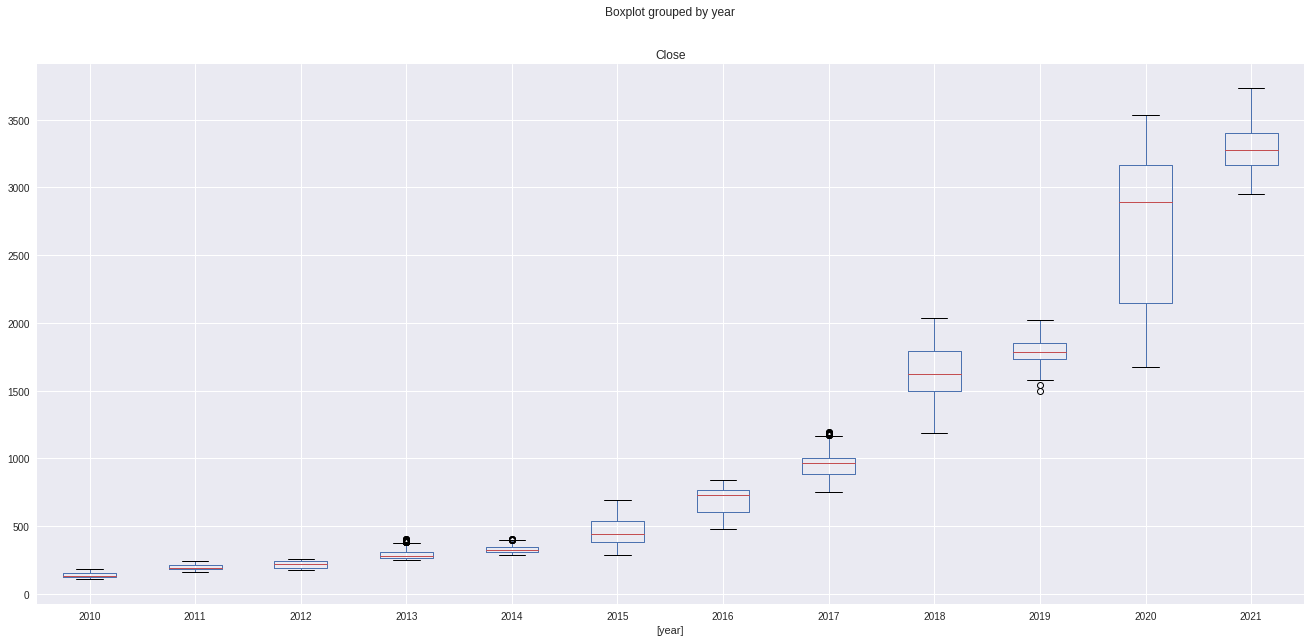

In [7]:
amzn_df["year"] = amzn_df["Date"].dt.year
amzn_df["month"] = amzn_df["Date"].dt.month
amzn_df["dayofweek"] = amzn_df["Date"].dt.dayofweek

amzn_df.boxplot(column=["Close"], by=["year"])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



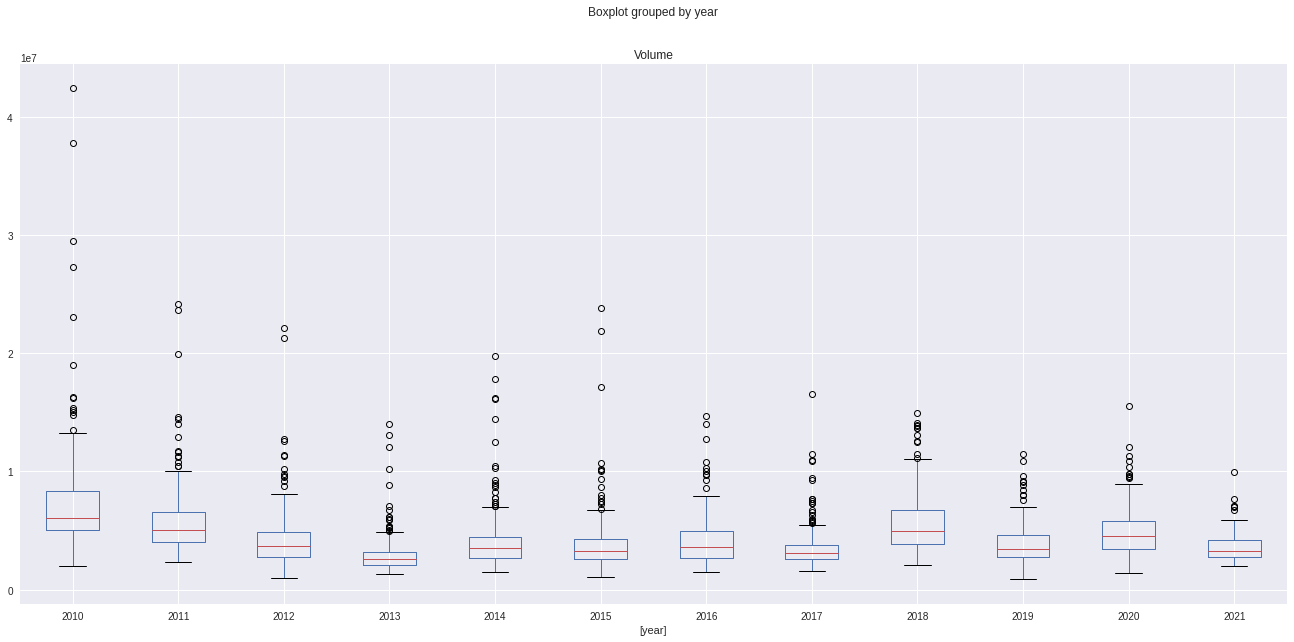

In [8]:
amzn_df.boxplot(column=["Volume"], by=["year"])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



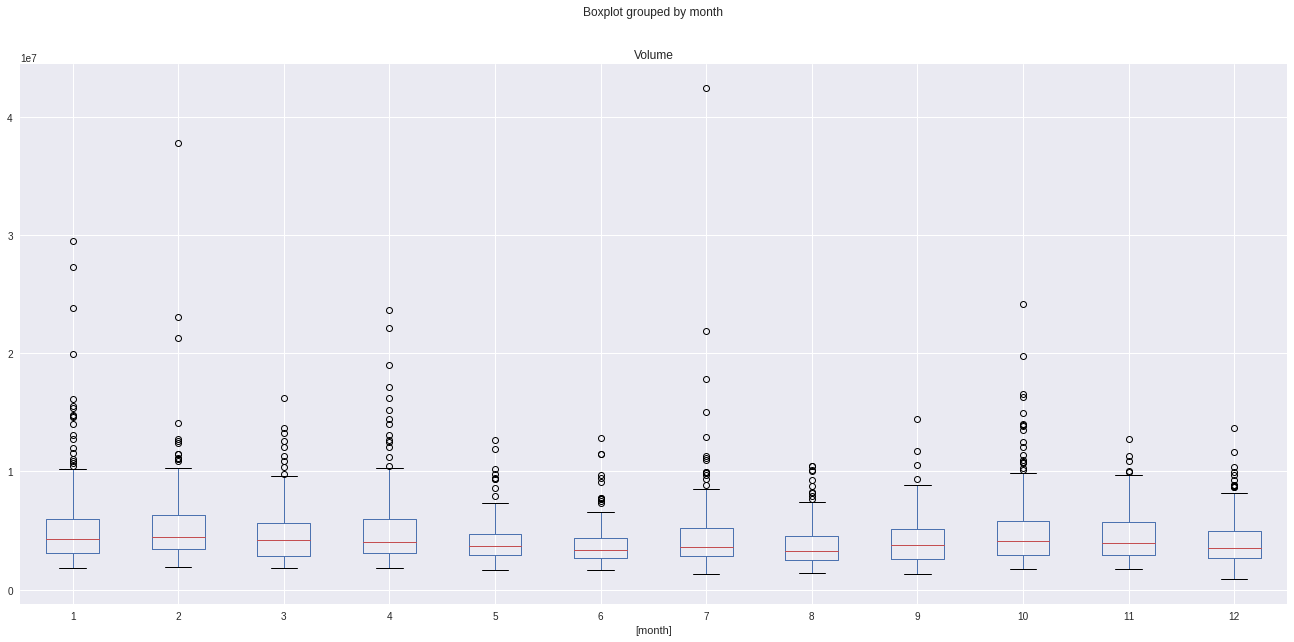

In [9]:
amzn_df.boxplot(column=["Volume"], by=["month"])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



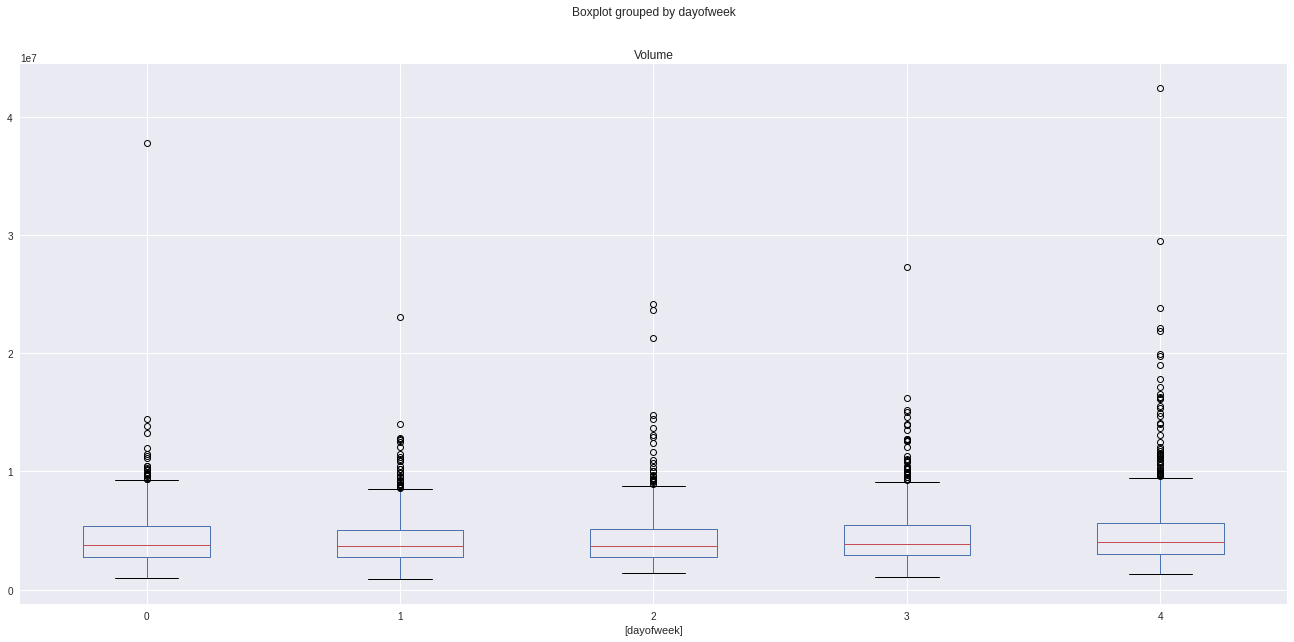

In [10]:
amzn_df.boxplot(column=["Volume"], by=["dayofweek"])

Histogram and Density Plots

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb8518f5b10>]],
      dtype=object)

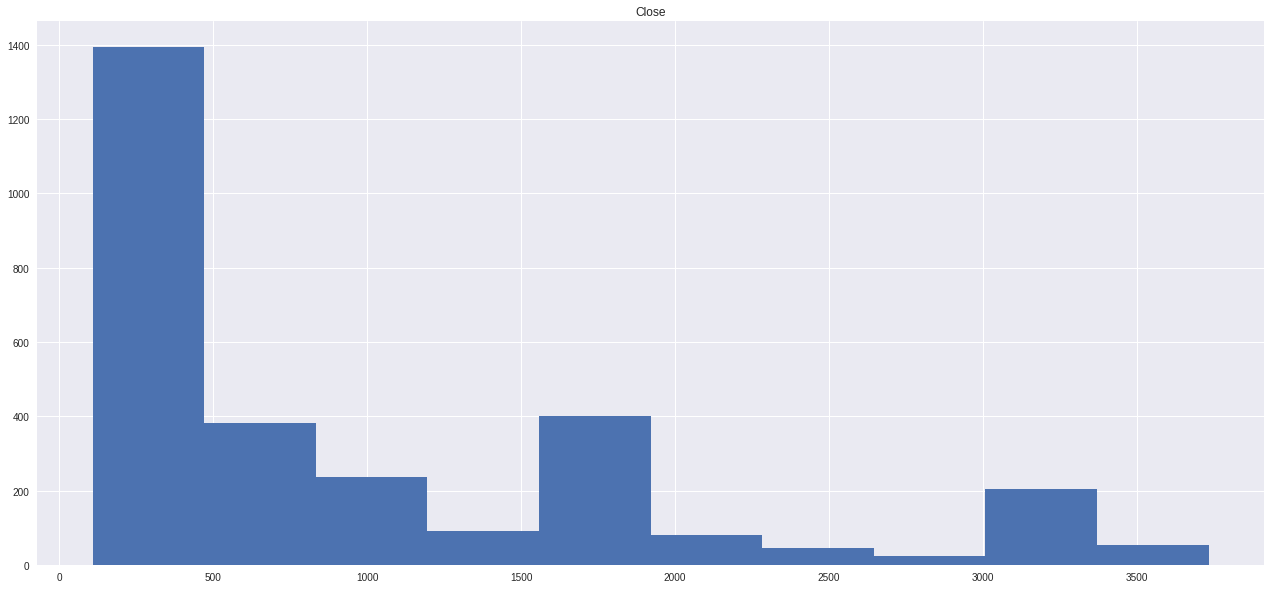

In [11]:
amzn_df.hist(column=["Close"])

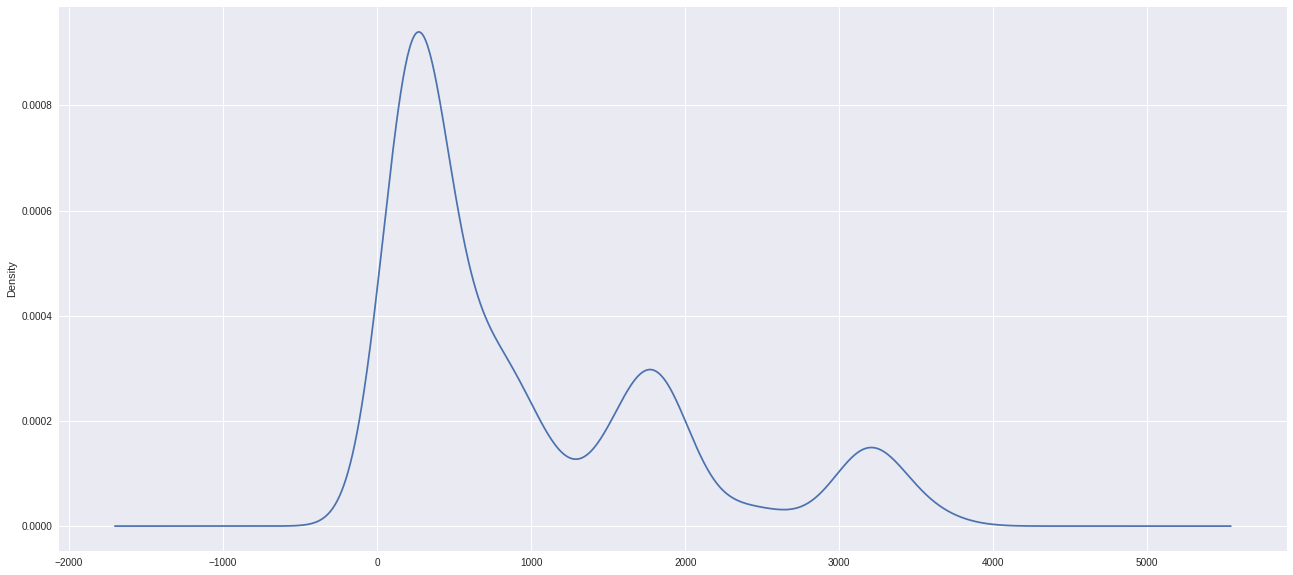

In [12]:
amzn_df['Close'].plot(kind='kde')

Let's try different exponential smoothing methods for stock price forecasting

In [13]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
#import statsmodels
import numpy as np
#import matplotlib.pyplot as plt                  # plots
#import seaborn as sns                            # more plots
from sklearn.model_selection import ParameterGrid
import random
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from scipy.optimize import minimize


def mean_absolute_percentage_error(y_true, y_pred): 
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)


class DoubleExpSmoothing:
  
  def __init__(self, lag):
    self.lag = lag
    self.alpha = None
    self.beta = None
    self.train = None

  def __double_exponential_smoothing(series, alpha, beta, horizon=31):
    """
    Given a series, alpha, beta and n_preds (number of
    forecast/prediction steps), perform the prediction.
    """
    n_record = series.shape[0]
    results = np.zeros(n_record + horizon)
    # first value remains the same as series,
    # as there is no history to learn from;
    # and the initial trend is the slope/difference
    # between the first two value of the series
    level = series[0]
    results[0] = series[0]
    trend = series[1] - series[0]
    for t in range(1, n_record + 1):
        if t >= n_record:
            # forecasting new points
            value = results[t - 1]
        else:
            value = series[t]

        previous_level = level
        level = alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - previous_level) + (1 - beta) * trend 
        results[t] = level + trend
   
    # for forecasting beyond the first new point,
    # the level and trend is all fixed
    if horizon > 1:
        results[n_record + 1:] = level + np.arange(2, horizon + 1) * trend
    return results[-horizon:]

  def __timeseriesCVscoreDouble(params, series, loss_function=mean_squared_error):
      """
          Returns error on CV  
          
          params - vector of parameters for optimization
          series - dataset with timeseries
          slen - season length for Holt-Winters model
      """
      # errors array
      errors = []
      
      values = series
      alpha, beta = params
      
      # set the number of folds for cross-validation
      tscv = TimeSeriesSplit(n_splits=5) 
      
      # iterating over folds, train model on each, forecast and calculate error
      for train, test in tscv.split(values):
          predictions = DoubleExpSmoothing.__double_exponential_smoothing(values[train], alpha, beta, horizon=len(test))
          actual = values[test]
          error = loss_function(predictions, actual)
          errors.append(error)
          
      return np.mean(np.array(errors))

  def fit(self, series):
    self.train = series[-self.lag:]
    params = [0, 0] 
    # Minimizing the loss function 
    opt = minimize(DoubleExpSmoothing.__timeseriesCVscoreDouble, x0=params, 
                args=(self.train, mean_squared_error), 
                method="TNC", bounds = ((0, 1), (0, 1))
                )
    self.alpha, self.beta = opt.x

  def forecast(self, horizon):
    y_smooth = DoubleExpSmoothing.__double_exponential_smoothing(self.train, self.alpha, self.beta, horizon)
    return y_smooth


def exp_smoothing_plot_prediction(df_src, dt_col, feature_name, period='D', horizon=31, base_lag=31):
  df = df_src[[dt_col, feature_name]].copy()
  df = df.set_index(dt_col)
  df.index = pd.DatetimeIndex(df.index).to_period(period) 
  
  test = df[-horizon:].copy()
  train = df[:-horizon].copy()
  
  # let's try different lag values

  model_3 = DoubleExpSmoothing(base_lag*3)
  model_3.fit(train[feature_name])
  y_double_exp_3 = model_3.forecast(horizon)
  
  double_exp_mape_3 = mean_absolute_percentage_error(test[feature_name].values, y_double_exp_3)

  model_5 = DoubleExpSmoothing(base_lag * 5)
  model_5.fit(train[feature_name])
  y_double_exp_5 = model_5.forecast(horizon)
  double_exp_mape_5 = mean_absolute_percentage_error(test[feature_name].values, y_double_exp_5)

  model_tripple_exp_3 = ExponentialSmoothing(train[-base_lag * 3:], seasonal='add', trend='add', initialization_method="estimated").fit()
  y_tripple_exp_3 = model_tripple_exp_3.forecast(horizon)
  tripple_exp_mape_3 = mean_absolute_percentage_error(test[feature_name].values, y_tripple_exp_3)
  
  model_tripple_exp_5 = ExponentialSmoothing(train[-base_lag * 5:], seasonal='add', trend='add', initialization_method="estimated").fit()
  y_tripple_exp_5 = model_tripple_exp_5.forecast(horizon)
  tripple_exp_mape_5 = mean_absolute_percentage_error(test[feature_name].values, y_tripple_exp_5)
  
  df_tgt = df_src[[dt_col, feature_name]].copy()
  df_tgt = df_tgt.set_index(dt_col)
  df_tgt =  df_tgt[-horizon*2:].copy()

  df_dt = df_src[[dt_col]].copy()
  df_dt = df_dt.set_index(dt_col)
  df_dt =  df_dt[-horizon:]
  
  df_double_exp_3 = df_dt.copy()
  df_double_exp_3[f'Double exp smoothing, train_lag {base_lag*3}, MAPE {double_exp_mape_3}'] = y_double_exp_3
  
  df_double_exp_5 = df_dt.copy()
  df_double_exp_5[f'Double exp smoothing, train_lag {base_lag*5}, MAPE {double_exp_mape_5}'] = y_double_exp_5
  
  df_tripple_exp_3 = df_dt.copy()
  df_tripple_exp_3[f'Tripple exp smoothing, train_lag {base_lag*3}, MAPE {tripple_exp_mape_3}'] = y_tripple_exp_3.values

  df_tripple_exp_5 = df_dt.copy()
  df_tripple_exp_5[f'Tripple exp smoothing, train_lag {base_lag*5}, MAPE {tripple_exp_mape_5}'] = y_tripple_exp_5.values
  
  pd.plotting.register_matplotlib_converters()
  with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    plt.rcParams.update({'font.size': 12})
    plt.plot(df_tgt, label=feature_name)
    plt.plot(df_double_exp_3, label=df_double_exp_3.columns[0])
    plt.plot(df_double_exp_5, label=df_double_exp_5.columns[0])
    plt.plot(df_tripple_exp_3, label=df_tripple_exp_3.columns[0])
    plt.plot(df_tripple_exp_5, label=df_tripple_exp_5.columns[0])
    plt.vlines(df_tgt.index[-horizon], ymin=min(df_tgt.values), ymax=max(df_tgt.values), linestyles='dashed')
    plt.legend(loc="best")
    plt.legend(frameon=True)
    plt.margins(x=0)
    plt.axis('tight')
    plt.title("Exponential smoothing")
    plt.grid(True)

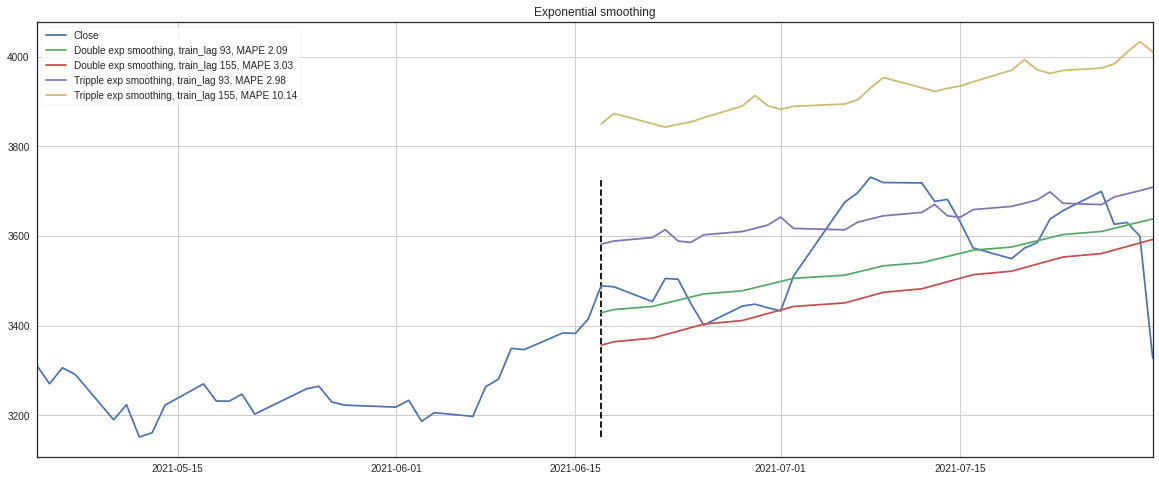

In [14]:
exp_smoothing_plot_prediction(amzn_df, 'Date', 'Close')

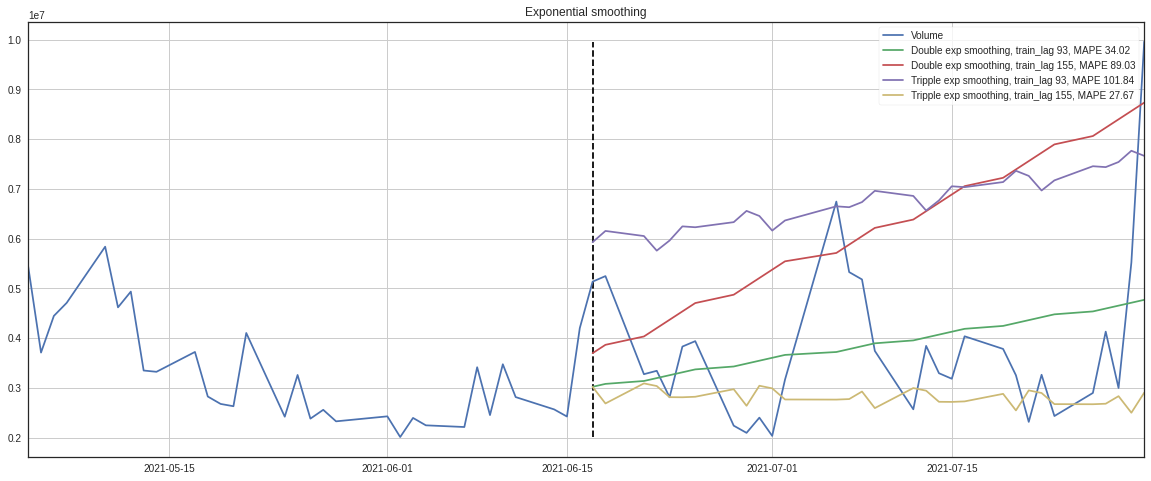

In [15]:
exp_smoothing_plot_prediction(amzn_df, 'Date', 'Volume')